In [1]:
import os
import torch
import argparse
import json
from pytorch_lightning import Trainer
from train_sample_utils import get_models, get_DDPM
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [2]:
import matplotlib.pyplot as plt
from callbacks.coco_layout.sampling_save_fig import ColorMapping, plot_bbox_without_overlap, plot_bounding_box
from data.coco_w_stuff import get_coco_id_mapping
import numpy as np
coco_id_mapping = get_coco_id_mapping()
def show_image(batched_x, batched_bbox):
    for x, bbox in zip(batched_x, batched_bbox):
        x = x.permute(1, 2, 0).detach().cpu().numpy().clip(-1, 1)
        x = (x + 1) / 2
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(x)
        ax[1].imshow(overlap_image_with_bbox(x, bbox))
        ax[2].imshow(overlap_image_with_bbox(np.ones_like(x), bbox))
        plt.show()

def overlap_image_with_bbox(image, bbox):
    label_color_mapper = ColorMapping(id_class_mapping=coco_id_mapping)
    image_with_bbox = plot_bbox_without_overlap(
        image.copy(),
        bbox,
        label_color_mapper
    ) if len(bbox) <= 10 else None
    if image_with_bbox is not None:
        return image_with_bbox
    return plot_bounding_box(
        image.copy(), 
        bbox,
        label_color_mapper
    )

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '-c', '--config', type=str, 
    default='config/train.json')
parser.add_argument(
    '-n', '--num_repeat', type=int, 
    default=1, help='the number of images for each condition')
parser.add_argument(
    '-e', '--epoch', type=int, 
    default=None, help='which epoch to evaluate, if None, will use the latest')
parser.add_argument(
    '--nnode', type=int, default=1
)

''' parser configs '''
args_raw = parser.parse_args(['-c', 'configs/cocostuff.json', '-e', '59'])
with open(args_raw.config, 'r') as IN:
    args = json.load(IN)
args.update(vars(args_raw))
# args['gpu_ids'] = [0] # DEBUG
expt_name = args['expt_name']
expt_dir = args['expt_dir']
expt_path = os.path.join(expt_dir, expt_name)
os.makedirs(expt_path, exist_ok=True)

In [4]:
'''1. create denoising model'''
denoise_args = args['denoising_model']['model_args']
models = get_models(args)

diffusion_configs = args['diffusion']
# diffusion_args['beta_schedule_args']['n_timestep'] = 10 # DEBUG
ddpm_model = get_DDPM(
    diffusion_configs=diffusion_configs,
    log_args=args,
    **models
)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
INFO: initialize denoising UNet from pretrained_models/LAION_text2img/unet.ckpt, NOTE: without partial attention layers
INFO: initialize VQVAE from pretrained_models/LAION_text2img/vqvae.ckpt
INFO: initialize text model from pretrained_models/LAION_text2img/bert.ckpt


In [5]:
'''2. create a dataloader which generates'''
from test_sample_utils import get_test_dataset, get_test_callbacks
test_dataset, test_loader = get_test_dataset(args)

'''3. callbacks'''
# we do not need it here when not using pytorch lightning Trainer
# callbacks = get_test_callbacks(args, expt_path)

called set_image_size (256, 256)
called set_image_size (256, 256)


'3. callbacks'

In [6]:
'''4. load checkpoint'''
print('INFO: loading checkpoint')
if args['epoch'] is None:
    ckpt_to_use = 'latest.ckpt'
else:
    ckpt_to_use = f'epoch={args["epoch"]:04d}.ckpt'
ckpt_path = os.path.join(expt_path, ckpt_to_use)
print(ckpt_path)
if os.path.exists(ckpt_path):
    print(f'INFO: Found checkpoint {ckpt_path}')
    ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
    # ckpt_denoise_fn = {k.replace('denoise_fn.', ''): v for k, v in ckpt.items() if 'denoise_fn' in k}
    # ddpm_model.denoise_fn.load_state_dict(ckpt_denoise_fn)
    ddpm_model.load_state_dict(ckpt)
else:
    ckpt_path = None
    raise RuntimeError('Cannot do inference without pretrained checkpoint')

INFO: loading checkpoint
experiments/cocostuff_LayoutDiffuse/epoch=0059.ckpt
INFO: Found checkpoint experiments/cocostuff_LayoutDiffuse/epoch=0059.ckpt


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ddpm_model = ddpm_model.to(device)

/home/ubuntu/disk1/layout_diffuse/DDIM_ldm/DDIM_ldm_coco.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'layout': torch.tensor(batch[1]),


Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.31it/s]


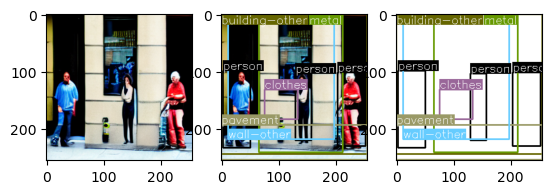

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.22it/s]


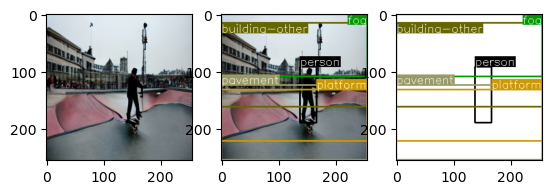

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


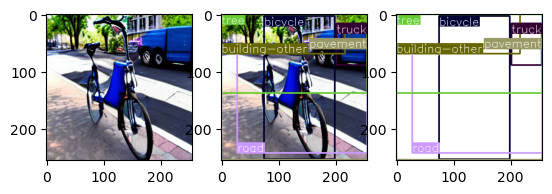

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


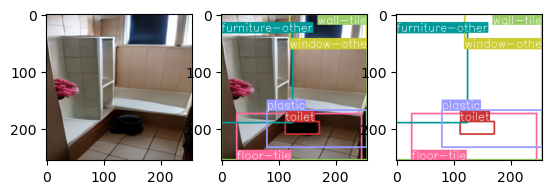

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


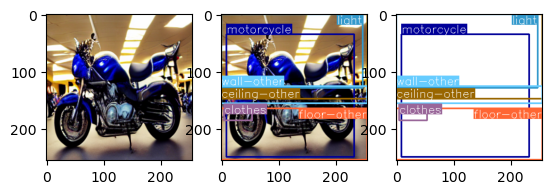

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


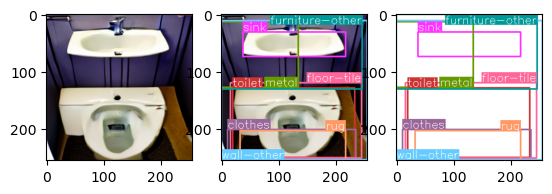

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


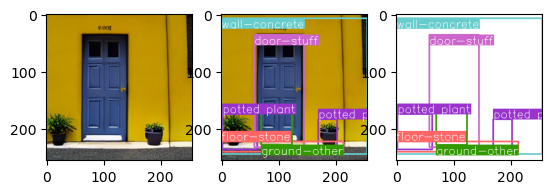

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


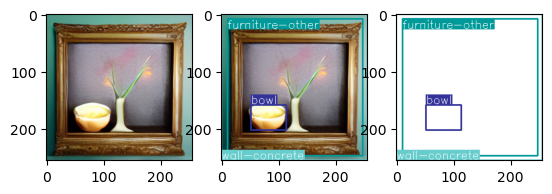

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.52it/s]


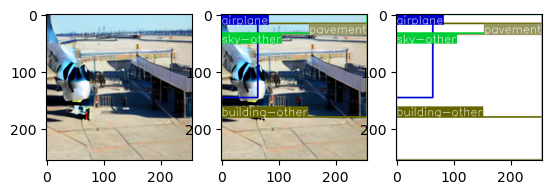

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:04<00:00,  4.64it/s]


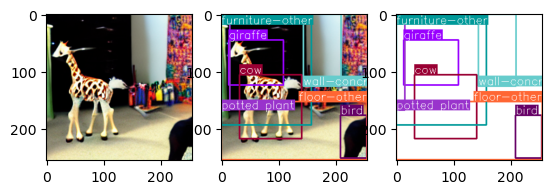

Data shape for PLMS sampling is (1, 4, 32, 32)
Running PLMS Sampling with 20 timesteps


PLMS Sampler: 100%|██████████| 20/20 [00:03<00:00,  5.19it/s]


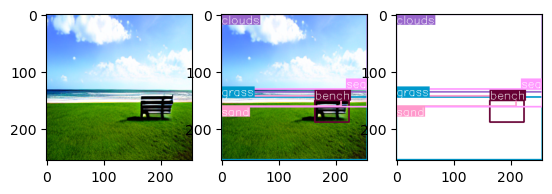

In [8]:
for batch_idx, batch in enumerate(test_loader):
    batch[0] = batch[0].to(device)
    batch[1] = batch[1].to(device)
    res = ddpm_model.test_step(batch, 0) # we pass a batch but only text and layout is used when sampling
    sampled_images = res['sampling']['model_output']
    show_image(sampled_images, batch[1].cpu())
    if batch_idx >= 10:
        break